#  SOCAT neural-network : First steps

This notebook contains all the code to run neural network using Tensorflow
Driver data includes: SST, SSS, MLD, CHL, CO2 and we are predicting fCO2

We are starting with monthly gridded observations 1998 - 2010

In [148]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

from sklearn.model_selection import train_test_split

%matplotlib inline

In [22]:
### Print if using CPU or GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15675570753498111639
]


### All you need to change is data_dir

In [2]:
data_dir='/Users/gloege/Documents/Projects/SOCAT-neural-network/data/data_driver_fixed/'
os.listdir(data_dir)

['SOCATv5_mask_199801-201012.nc',
 'SALT_1x1_199801-201012.nc',
 'MXLDEPTH_1x1_199801-201012.nc',
 'co2_avg_199801-201012.nc',
 'sst_1x1_199801-201012.nc',
 'biomes.nc',
 'SOCATv5_gridded_monthly_199801-201012.nc',
 'Chl_1x1_199801-201012.nc']

# 1. Get the data and sample like it's SOCAT

In [3]:
### SOCAT data paths
fl_mask = data_dir + 'SOCATv5_mask_199801-201012.nc'
fl_socat = data_dir + 'SOCATv5_gridded_monthly_199801-201012.nc'

### Driver data paths
fl_sss = data_dir + 'SALT_1x1_199801-201012.nc'
fl_mld = data_dir + 'MXLDEPTH_1x1_199801-201012.nc'
fl_co2 = data_dir + 'co2_avg_199801-201012.nc'
fl_sst = data_dir + 'sst_1x1_199801-201012.nc'
fl_chl = data_dir + 'Chl_1x1_199801-201012.nc'

### biomes
fl_biomes = data_dir + 'biomes.nc'

In [4]:
### SOCAT data 
ds_mask = xr.open_dataset(fl_mask)
ds_socat = xr.open_dataset(fl_socat)

### Driver data
ds_sss = xr.open_dataset(fl_sss)
ds_mld = xr.open_dataset(fl_mld)
ds_co2 = xr.open_dataset(fl_co2)
ds_sst = xr.open_dataset(fl_sst)
ds_chl = xr.open_dataset(fl_chl)

### Biomes
ds_biomes = xr.open_dataset(fl_biomes)
#mask = ds['socat_mask'].roll(xlon=-180)

In [5]:
### Make sure all the same dimensions
print('Make sure all same dimensions')
print(ds_mask['socat_mask'].shape)
print(ds_socat['FCO2_AVE_UNWTD'].shape)
print(ds_sss['SALT'].shape)
print(ds_sst['sst'].shape)
print(ds_chl['Chl'].shape)
print(ds_mld['MXLDEPTH'].shape)
print(ds_co2['co2'].shape) 


Make sure all same dimensions
(156, 180, 360)
(156, 180, 360)
(156, 180, 360)
(156, 180, 360)
(156, 180, 360)
(156, 180, 360)
(156,)


In [6]:
### Make sure all the same dimensions
print('Make sure longitudes are 0 - 360')
print(ds_mask['xlon'].values[0])
print(ds_socat['xlon'].values[0])
print(ds_sss['tlon'].values[0])
print(ds_sst['tlon'].values[0])
print(ds_chl['tlon'].values[0])
print(ds_mld['tlon'].values[0])

Make sure longitudes are 0 - 360
0.5
0.5
0.5
0.5
0.5
0.5


In [7]:
### Grid
lon = ds_socat['xlon']
lat = ds_socat['ylat']
time = ds_socat['tmnth']

### Data
mask = ds_mask['socat_mask'].values
fco2 = ds_socat['FCO2_AVE_UNWTD'].values
sss = ds_sss['SALT'].values
sst = ds_sst['sst'].values
chl = ds_chl['Chl'].values
mld = ds_mld['MXLDEPTH'].values

### This tiles CO2 so same shape as the others.
co2 = np.tile(ds_co2['co2'].values[:, np.newaxis, np.newaxis],(1,180,360))

### Show me the shape of co2
print('The shape of CO2 is now : ' + str(co2.shape))

The shape of CO2 is now : (156, 180, 360)


In [8]:
tlon, tlat = np.meshgrid(lon,lat)
biomes = np.swapaxes(ds_biomes['MeanBiomes'].roll(lon=-180),0,1).values
biomes.shape
#inds0, inds1 = np.where(biomes==3)
#biomes.shape
#plt.pcolor(tlon[inds0, inds1],tlat[inds0, inds1],biomes[inds0, inds1])
#plt.show()

(180, 360)

## Maximum of each variable
I am taking the max of the unsampled (i.e. not sampled like SOCAT) and dividing this by the vector to normalize it between 0 and 1

In [9]:
fco2_max = np.nanmax(fco2)

### drivers
sss_max = np.nanmax(sss)
sst_max = np.nanmax(sst)
chl_max = np.nanmax(chl)
mld_max = np.nanmax(mld)
co2_max = np.nanmax(co2)

print('max sss ' + str(sss_max))
print('max sst ' + str(sst_max))
print('max chl ' + str(chl_max))
print('max mld ' + str(mld_max))
print('max co2 ' + str(co2_max))

max sss 39.7352581024
max sst 34.82
max chl 99.2970428467
max mld 3564.49597168
max co2 390.11925


## Mask the data like it is SOCAT

In [10]:
fco2_ma = np.ma.masked_array(fco2, mask=(mask==0))/fco2_max

sst_ma = np.ma.masked_array(sst, mask=(mask==0))/sst_max
sss_ma = np.ma.masked_array(sss, mask=(mask==0))/sss_max
chl_ma = np.ma.masked_array(chl, mask=(mask==0))/chl_max
mld_ma = np.ma.masked_array(mld, mask=(mask==0))/mld_max
co2_ma = np.ma.masked_array(co2, mask=(mask==0))/co2_max

## Driver data in large matrix and output

In [ ]:
### Define a meshgrid from lon and lat
lon_mesh, lat_mesh = np.meshgrid(lon,lat)

### Tile the meshgrid to the number of time steps
lat_tiled = np.tile(lat_mesh[np.newaxis, :, :],(len(time),1, 1))
lon_tiled = np.tile(lon_mesh[np.newaxis, :, :],(len(time),1, 1))

### plot it
#plt.pcolor(lon_tiled[100,:,:],lat_tiled[30,:,:],sst[0,:,:])

In [93]:
time_tiled = np.tile(time.values[:, np.newaxis, np.newaxis],(1,180,360))
time_tiled.shape

(156, 180, 360)

In [98]:
### biomes
fl_biomes = data_dir + 'biomes.nc'

### Get Mean biomes and make lon 0-360
mean_biomes = np.swapaxes(ds_biomes['MeanBiomes'].roll(lon=-180),0,1).values

### biomes_tiled
biomes_tiled = np.tile(mean_biomes[np.newaxis, :, :],(len(time),1, 1))

### Replace nans with zero
biomes_land = np.isnan(mean_biomes)
mean_biomes[biomes_land] = 0

### Use tensorflow to one-hot encode
with tf.Session() as sess:
    biomes_one_hot = sess.run(tf.one_hot(mean_biomes,18))

### Tile biomes_one_hot
biomes_one_hot_tiled = np.tile(biomes_one_hot[np.newaxis, :, :, :],(len(time),1, 1, 1))

### plot one of the biomes
print(one_hot.shape)
plt.pcolor(lon,lat,biomes_one_hot[:,:,4])

(156, 180, 360)

(10108800,)

![mean_biomes](https://doi.pangaea.de/10013/epic.42948.d004)

# BIOMES IS A PREDICTOR AS 1-16
### NOT A GOOD IDEA!!!!
Use one-hot encoding. Maybe tensorflow can help? https://www.tensorflow.org/api_docs/python/tf/one_hot

In [179]:
### What is driving the model
driver = np.transpose(np.stack((sst_ma.flatten(),     # SST
                                sss_ma.flatten(),     # SSS 
                                chl_ma.flatten(),     # Chl
                                mld_ma.flatten(),     # MLD
                                co2_ma.flatten(),     # atm. CO2
                                #lon_tiled.flatten(),  # Longitude
                                #lat_tiled.flatten(),  # Latitude
                                #time_tiled.flatten(), # time
                                ### Biomes are one-hot encoded ###
                                biomes_one_hot_tiled[:,:,:,0].flatten(), # <-- This one is 1 where there is land
                                biomes_one_hot_tiled[:,:,:,1].flatten(),
                                biomes_one_hot_tiled[:,:,:,2].flatten(),
                                biomes_one_hot_tiled[:,:,:,3].flatten(),
                                biomes_one_hot_tiled[:,:,:,4].flatten(),
                                biomes_one_hot_tiled[:,:,:,5].flatten(),
                                biomes_one_hot_tiled[:,:,:,6].flatten(),
                                biomes_one_hot_tiled[:,:,:,7].flatten(),
                                biomes_one_hot_tiled[:,:,:,8].flatten(),
                                biomes_one_hot_tiled[:,:,:,9].flatten(),
                                biomes_one_hot_tiled[:,:,:,10].flatten(),
                                biomes_one_hot_tiled[:,:,:,11].flatten(),
                                biomes_one_hot_tiled[:,:,:,12].flatten(),
                                biomes_one_hot_tiled[:,:,:,13].flatten(),
                                biomes_one_hot_tiled[:,:,:,14].flatten(),
                                biomes_one_hot_tiled[:,:,:,15].flatten(),
                                biomes_one_hot_tiled[:,:,:,16].flatten(),
                                biomes_one_hot_tiled[:,:,:,17].flatten(),
                               )))

### What the true value is 
true_value = fco2_ma.flatten()

print('shape of driver: ' + str(driver.shape))
print('shape of true_value: ' + str(true_value.shape))

shape of driver: (10108800, 23)
shape of true_value: (10108800,)


## Remove rows with NaN
I am calling these driver_nn and true_value_nn

In [180]:
#
#nan_mask = ~np.isnan(driver).any(axis=1)
nan_mask=(~np.isnan(driver).any(axis=1)) & (~np.isnan(true_value))

In [181]:
#nan_mask = ~np.isnan(driver).any(axis=1)

In [182]:
driver_nn = driver[nan_mask]
true_value_nn = true_value[nan_mask]

In [183]:
print('shape of driver_nn: ' + str(driver_nn.shape))
print('shape of true_value_nn: ' + str(true_value_nn.shape))

shape of driver_nn: (113712, 23)
shape of true_value_nn: (113712,)


## Split into training and testing

In [184]:
X_train, X_test, y_train, y_test = train_test_split(driver_nn, true_value_nn, random_state=42)

In [185]:
print('shape of X_train: ' + str(X_train.shape))
print('shape of X_test: ' + str(X_test.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of y_test: ' + str(y_test.shape))

shape of X_train: (85284, 23)
shape of X_test: (28428, 23)
shape of y_train: (85284,)
shape of y_test: (28428,)


In [186]:
#tmp = ~np.isnan(true_value_nn)
#print(np.sum(tmp))
#print(tmp.shape)

# 2. Building a network

In [196]:
### Model architecture
model = Sequential()
model.add(Dense(20, input_shape=(23,), 
          activation='relu',
          kernel_initializer=keras.initializers.random_normal(seed=42)))
model.add(Dense(1, 
          activation='linear',
          kernel_initializer=keras.initializers.random_normal(seed=42)))


In [197]:
model.compile(optimizer='adam',
              loss='mse')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 20)                480       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 21        
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________


In [198]:
history_callback = model.fit(X_train, y_train, epochs=10, verbose=1)

Epoch 1/10
85284/85284 [==============================] - 4s 41us/step - loss: 9.5800e-05
Epoch 2/10
85284/85284 [==============================] - 3s 37us/step - loss: 6.9575e-05
Epoch 3/10
85284/85284 [==============================] - 4s 41us/step - loss: 6.6632e-05
Epoch 4/10
85284/85284 [==============================] - 3s 37us/step - loss: 6.5536e-05
Epoch 5/10
85284/85284 [==============================] - 4s 45us/step - loss: 6.4307e-05
Epoch 6/10
85284/85284 [==============================] - 4s 47us/step - loss: 6.3756e-05
Epoch 7/10
85284/85284 [==============================] - 4s 41us/step - loss: 6.3416e-05
Epoch 8/10
85284/85284 [==============================] - 4s 48us/step - loss: 6.3114e-05
Epoch 9/10
85284/85284 [==============================] - 3s 39us/step - loss: 6.2988e-05
Epoch 10/10
85284/85284 [==============================] - 3s 38us/step - loss: 6.2874e-05


In [73]:
#score = model.evaluate(X_test, y_test, verbose=0)
#print("Test loss: {:.3f}".format(score[0]))
#print("Test Accuracy: {:.3f}".format(score[1]))

In [199]:
y_pred = model.predict(X_test, verbose=1)

28428/28428 [==============================] - 0s 16us/step


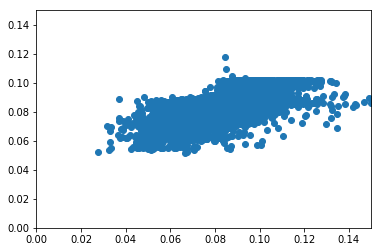

In [200]:
plt.scatter(y_test, y_pred)
plt.ylim([0,0.15])
plt.xlim([0,0.15])
plt.show()